# Análise de Risco de Investimentos

## 1. Introdução

Neste notebook, realizaremos uma análise de risco para investimentos em ativos financeiros do mercado brasileiro. A análise utiliza:

- **Carteira de Pesos Iguais**: Onde todos os ativos possuem o mesmo peso no portfólio (para comparação).
- **Carteira Otimizada (Markowitz)**: Otimizada para minimizar a volatilidade com base na matriz de covariância dos retornos.
- **Comparação com o Índice IBOVESPA (BOVA11)**: Usado como benchmark.

### Metodologia
Os cálculos realizados incluem:
1. **Retornos Diários**: Calculados com base nos preços ajustados dos ativos.
2. **Volatilidade Anualizada**: Usada para avaliar o risco.
3. **Carteira Otimizada**: Calculada utilizando o método de Markowitz para encontrar a combinação ideal de ativos que minimize o risco.
4. **Retorno Acumulado**: Mostra a performance dos portfólios no período selecionado.

O notebook também permite ao usuário escolher:
- Os ativos para compor o portfólio.
- O período de análise: 1M (1 mês), 6M (6 meses), 1Y (1 ano), 3Y (3 anos) ou 5Y (5 anos).

### Objetivo
Este notebook ajuda investidores a visualizar e comparar a performance de diferentes estratégias de alocação de ativos. Os resultados são apresentados graficamente para facilitar a análise.

## 2. Importação de Bibliotecas

In [41]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.optimize import minimize
from datetime import datetime, timedelta

## 3. Configuração dos Ativos

In [42]:
ativos = {
    # Ativo Principal
    "IBOVESPA": "BOVA11.SA",  

    # Ativos Brasileiros
    "PETROBRAS": "PETR4.SA",    
    "JBS": "JBSS3.SA",          
    "ITAU": "ITUB4.SA",         
    "VALE3": "VALE3.SA",        
    "WEG": "WEGE3.SA",          
    "AMBEV": "ABEV3.SA",        
    "BB": "BBAS3.SA",           
    "BTG": "BPAC11.SA",         
    "BRADESCO": "BBDC4.SA",     
    "SANTANDER": "SANB11.SA",   
}

## 4. Definição de Funções

### Função para Determinar o Período

In [43]:
def definir_periodo(escolha):
    fim = datetime.now()
    if escolha == "1M":
        inicio = fim - timedelta(days=30)
    elif escolha == "6M":
        inicio = fim - timedelta(days=182)
    elif escolha == "1Y":
        inicio = fim - timedelta(days=365)
    elif escolha == "5Y":
        inicio = fim - timedelta(days=5 * 365)
    else:
        raise ValueError("Escolha inválida! Use: 1M, 6M, 1Y ou 5Y.")
    return inicio, fim

### Função para Baixar Dados

In [44]:
def baixar_dados(escolhas, periodo):
    inicio, fim = definir_periodo(periodo)
    ativos_selecionados = [ativos[ativo] for ativo in escolhas]
    dados = yf.download(ativos_selecionados, start=inicio, end=fim.strftime('%Y-%m-%d'))["Adj Close"]
    dados.columns = escolhas
    return dados.dropna()

### Funções para Calcular Carteiras

- Carteira de Pesos Iguais

In [45]:
def calcular_pesos_iguais(retornos):
    num_ativos = len(retornos.columns)
    pesos = np.array([1 / num_ativos] * num_ativos)
    retorno_carteira = (retornos @ pesos).cumsum()
    return pesos, retorno_carteira

- Carteira Otimizada (Markowitz)

In [46]:
def calcular_carteira_otimizada(retornos):
    cov_matrix = retornos.cov() * 252
    num_ativos = len(retornos.columns)

    def objetivo(pesos):
        return np.sqrt(np.dot(pesos.T, np.dot(cov_matrix, pesos)))

    restricao = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    limites = tuple((0, 1) for _ in range(num_ativos))
    pesos_iniciais = np.array([1 / num_ativos] * num_ativos)

    resultado = minimize(objetivo, pesos_iniciais, method="SLSQP", bounds=limites, constraints=restricao)
    pesos = resultado.x
    retorno_carteira = (retornos @ pesos).cumsum()
    return pesos, retorno_carteira

### Funções de Visualização

- Gerar Matriz de Correlação

In [47]:
def gerar_matriz_correlacao(retornos):
    """Gera a matriz de correlação e a exibe como um heatmap."""
    correlacao = retornos.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlacao, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
    plt.title("Matriz de Correlação dos Ativos Selecionados")
    plt.show()
    return correlacao

- Gerar Gráfico

In [48]:
def gerar_grafico(retorno_iguais, retorno_otimizado, retorno_ibov):
    """Gera o gráfico de comparação de retornos acumulados com valores finais na legenda."""
    plt.figure(figsize=(14, 8))
    
    # Valores finais
    final_values = {
        "Carteira Otimizada": (retorno_otimizado.iloc[-1].item(), "green"),
        "Carteira Pesos Iguais": (retorno_iguais.iloc[-1].item(), "lightgreen"),
        "IBOVESPA (BOVA11)": (retorno_ibov.iloc[-1].item(), "blue"),
    }

    # Plotar os retornos acumulados
    plt.plot(retorno_otimizado, label=f"Carteira Otimizada ({final_values['Carteira Otimizada'][0]:+.2%})", color="green")
    plt.plot(retorno_iguais, label=f"Carteira Pesos Iguais ({final_values['Carteira Pesos Iguais'][0]:+.2%})", color="lightgreen", linestyle="--")
    plt.plot(retorno_ibov, label=f"IBOVESPA (BOVA11) ({final_values['IBOVESPA (BOVA11)'][0]:+.2%})", color="blue")
    
    # Linha no eixo zero
    plt.axhline(0, color="gray", linestyle="--", linewidth=1, alpha=0.8)
    
    # Configuração do eixo Y (em porcentagem)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
    
    # Configuração do eixo X (com meses abreviados)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    # Adicionar rótulos finais no gráfico
    for label, (value, color) in final_values.items():
        bbox_props = dict(
            boxstyle="round,pad=0.3", 
            edgecolor="none", 
            facecolor=color, 
            alpha=0.6
        )
        plt.text(retorno_otimizado.index[-1], value, f"{value:+.2%}",
                 fontsize=12, color="white", ha="left", va="center", bbox=bbox_props)

    # Configuração final do gráfico
    plt.title("Comparação de Carteiras")
    plt.xlabel("Período")
    plt.ylabel("Retorno Acumulado (%)")
    plt.legend(loc="upper left")  # Legenda movida para o canto superior esquerdo
    plt.grid()
    plt.show()


## 5. Escolha dos Ativos e Período

In [49]:
# Simulação com escolhas do usuário
escolhas_usuario = ["PETROBRAS", "ITAU", "JBS", "BB", "BRADESCO", "SANTANDER"]  # Exemplo de escolha do usuário
periodo_usuario = "1Y"  # Exemplo de escolha do período (1M, 6M, 1Y, 3Y ou 5Y)

## 6. Execução do Cálculo e Visualização

[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  1 of 1 completed


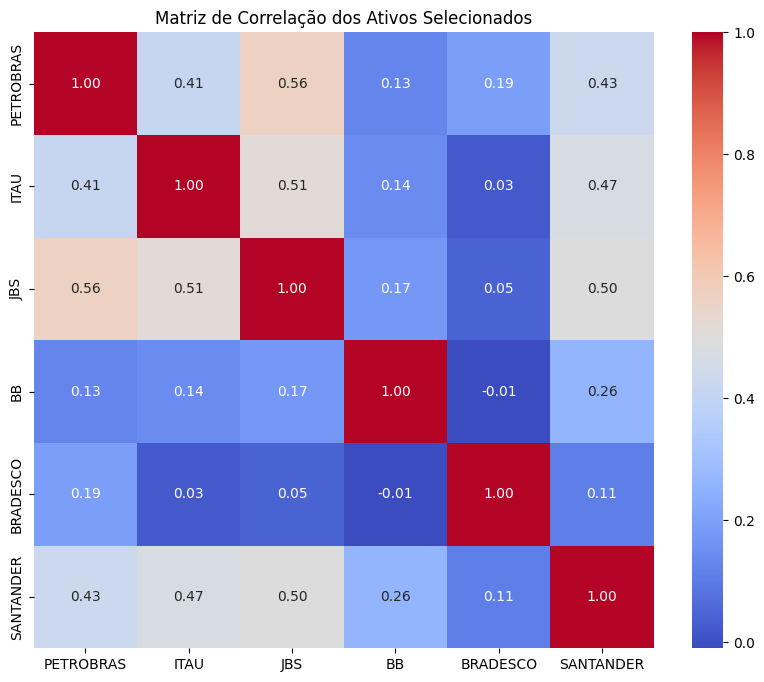

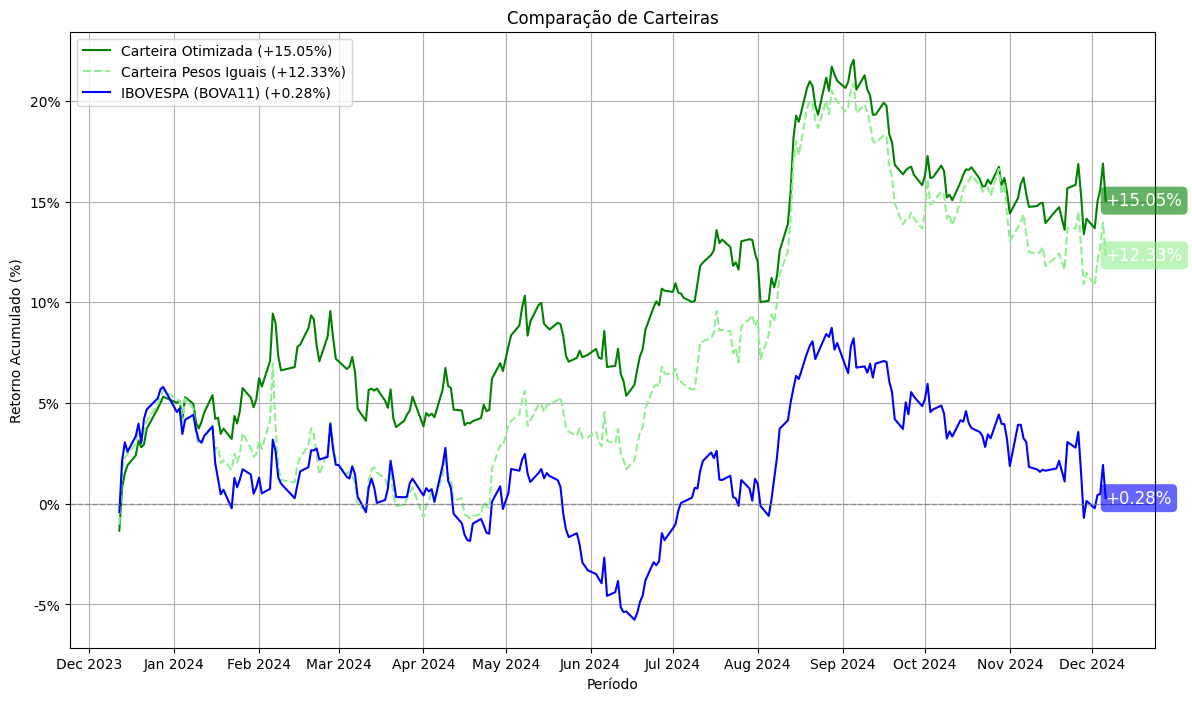


Pesos Iguais da Carteira:
PETROBRAS: 16.67%
ITAU: 16.67%
JBS: 16.67%
BB: 16.67%
BRADESCO: 16.67%
SANTANDER: 16.67%

Pesos Otimizados da Carteira:
PETROBRAS: 29.01%
ITAU: 1.15%
JBS: 25.48%
BB: 11.93%
BRADESCO: 22.28%
SANTANDER: 10.15%


In [50]:
# Baixando dados
dados_escolhidos = baixar_dados(escolhas_usuario, periodo_usuario)
retornos = dados_escolhidos.pct_change().dropna()

# Calculando carteiras
pesos_iguais, retorno_iguais = calcular_pesos_iguais(retornos)
pesos_otimizados, retorno_otimizado = calcular_carteira_otimizada(retornos)

# Comparação com IBOVESPA (BOVA11)
dados_ibov = baixar_dados(["IBOVESPA"], periodo_usuario)
retorno_ibov = dados_ibov.pct_change().dropna().cumsum()

# Exibir a matriz de correlação
correlacao = gerar_matriz_correlacao(retornos)

# Gerar o gráfico
gerar_grafico(retorno_iguais, retorno_otimizado, retorno_ibov)

# Exibir resultados
print("\nPesos Iguais da Carteira:")
for ativo, peso in zip(escolhas_usuario, pesos_iguais):
    print(f"{ativo}: {peso:.2%}")

print("\nPesos Otimizados da Carteira:")
for ativo, peso in zip(escolhas_usuario, pesos_otimizados):
    print(f"{ativo}: {peso:.2%}")